<a href="https://www.kaggle.com/code/komangandika/textfinal-2501994424?scriptVersionId=160662875" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import torch`
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import os

In [3]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim import corpora, models

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-1c/data_1C.csv
/kaggle/input/data-3c/data_3C.txt
/kaggle/input/data-2c/data_2C.csv


## <p style="border: 2px solid black; font-family: Arial, sans-serif; font-size: 200%; text-align: center; color: black; padding: 10px;border-radius: 10px;">1. Text Classification</p>

In [2]:
df = pd.read_csv('/kaggle/input/data-1c/data_1C.csv')

In [3]:
df.head()

,Unnamed: 0,text,label
0,0,Doxazosin for the treatment of chronic congest...,nervous system diseases
1,1,Serum ferritin and stomach cancer risk among a...,digestive system diseases
2,2,Detection and evaluation of intrapulmonary vas...,nervous system diseases
3,3,Acute cholangitis. Cholangitis is an infection...,cardiovascular diseases
4,4,The variable extent of jeopardized myocardium ...,nervous system diseases


In [4]:
df.shape

(3609, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3609 entries, 0 to 3608
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3609 non-null   int64 
 1   text        3609 non-null   object
 2   label       3609 non-null   object
dtypes: int64(1), object(2)
memory usage: 84.7+ KB


Drop column Unnamed: 0 dikarenakan sudah terdapat index

In [6]:
df.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [7]:
df.head()

,text,label
0,Doxazosin for the treatment of chronic congest...,nervous system diseases
1,Serum ferritin and stomach cancer risk among a...,digestive system diseases
2,Detection and evaluation of intrapulmonary vas...,nervous system diseases
3,Acute cholangitis. Cholangitis is an infection...,cardiovascular diseases
4,The variable extent of jeopardized myocardium ...,nervous system diseases


In [8]:
df.isna().sum()

text     0
label    0
dtype: int64

In [9]:
df.duplicated().any()

False

Tidak terdapat missing value dan duplicate value

## Problem Understanding

Problem yang akan kita selesaikan adalah multi-class text classification dengan dataset kesehatan.

## Target Distribution

In [10]:
df['label'].value_counts()

label
general pathological conditions    1248
digestive system diseases           765
nervous system diseases             735
neoplasms                           484
cardiovascular diseases             377
Name: count, dtype: int64

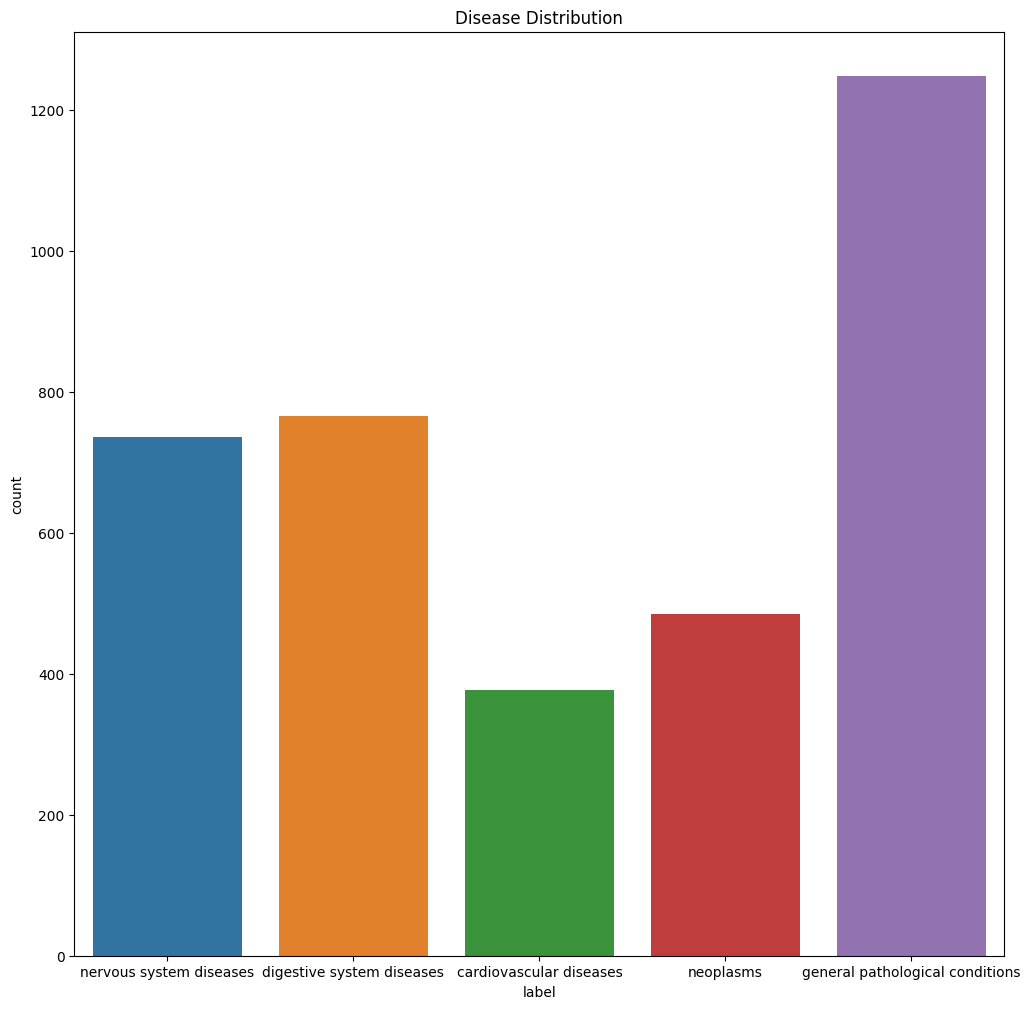

In [11]:
plt.figure(figsize=(12, 12))
sns.countplot(x=df['label'])
plt.title('Disease Distribution')
plt.show()

Terlihat bahwa pada dataset ini terdapat 5 label, yaitu nervous system diseases, digestive system diseases, cardiovascular diseases, neoplasm, dan general pathological conditions. Persebaran label terlihat imbalance dengan general pathological condition.

## Tokenizing + LLM Model (BERT)

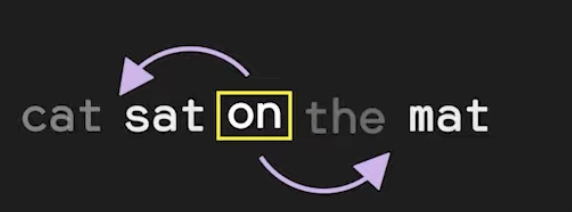

BERT atau Bidirectional Encoder Representations from Transformers merupakan salah satu LLM yang paling terkenal, Bidirectional berarti attention pada BERT mampu untuk melihat token sebelum dan token yang akan datang selagi memberikan output.

Pada problem ini saya menggunakan bert-base-cased, bert memiliki 2 model yaitu bert-base dan bert-large yang membedakannya adalah bert base dengan 12 enoders dan bert large dengan 24 encoder.

Untuk problem ini, menurut saya bert-base sudah cukup dengan cased yang berarti membedakan antara huruf besar dan kecil.

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'nervous system diseases': 0,
 'digestive system diseases': 1,
 'cardiovascular diseases': 2,
 'neoplasms': 3,
 'general pathological conditions': 4}

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
# Preparing the data for BERT model
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [15]:
# Splitting dataset
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

2887 361 361


In [17]:
# Model Initialization
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

Berikut merupakan model BERT yang digunakan: <br>
self.dropout = nn.Dropout(dropout) - dropout ginakan untuk menghidari terjadinya overfitting.<br>
self.linear = nn.Linear(768, 5) - layer linear ini digunakan untuk problem classification dengan hidden layer berjumlah 768 dan outputnya 5 yang sesuai dengan jumlah unique label yang kita miliki.<br>
self.relu = nn.ReLU() - Merupakan activation function.<br>

In [23]:
def train(model, train_data, val_data, learning_rate, epochs):

    train_dataset, val_dataset = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0
        all_preds_train = []
        all_labels_train = []

        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            # Collect predictions and labels for metrics calculation
            all_preds_train.extend(output.argmax(dim=1).cpu().numpy())
            all_labels_train.extend(train_label.cpu().numpy())

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # Calculate metrics for training set
        train_precision = precision_score(all_labels_train, all_preds_train, average='weighted')
        train_recall = recall_score(all_labels_train, all_preds_train, average='weighted')
        train_f1 = f1_score(all_labels_train, all_preds_train, average='weighted')

        total_acc_val = 0
        total_loss_val = 0
        all_preds_val = []
        all_labels_val = []

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

                # Collect predictions and labels for metrics calculation
                all_preds_val.extend(output.argmax(dim=1).cpu().numpy())
                all_labels_val.extend(val_label.cpu().numpy())

        # Calculate metrics for validation set
        val_precision = precision_score(all_labels_val, all_preds_val, average='weighted')
        val_recall = recall_score(all_labels_val, all_preds_val, average='weighted')
        val_f1 = f1_score(all_labels_val, all_preds_val, average='weighted')

        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data):.3f} \
            | Train Accuracy: {total_acc_train / len(train_data):.3f} \
            | Train Precision: {train_precision:.3f} \
            | Train Recall: {train_recall:.3f} \
            | Train F1: {train_f1:.3f} \
            | Val Loss: {total_loss_val / len(val_data):.3f} \
            | Val Accuracy: {total_acc_val / len(val_data):.3f} \
            | Val Precision: {val_precision:.3f} \
            | Val Recall: {val_recall:.3f} \
            | Val F1: {val_f1:.3f}')


In [26]:
def evaluate(model, test_data):
    test_dataset = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    all_preds_test = []
    all_labels_test = []

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            # Collect predictions and labels for metrics calculation
            all_preds_test.extend(output.argmax(dim=1).cpu().numpy())
            all_labels_test.extend(test_label.cpu().numpy())

    # Calculate metrics for the test set
    test_accuracy = accuracy_score(all_labels_test, all_preds_test)
    test_precision = precision_score(all_labels_test, all_preds_test, average='weighted')
    test_recall = recall_score(all_labels_test, all_preds_test, average='weighted')
    test_f1 = f1_score(all_labels_test, all_preds_test, average='weighted')

    print(
        f'Test Accuracy: {test_accuracy:.3f} \
        | Test Precision: {test_precision:.3f} \
        | Test Recall: {test_recall:.3f} \
        | Test F1: {test_f1:.3f}')


In [24]:
# First Model with LR = 1e-6 and Epochs = 5
EPOCHS = 5
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 1444/1444 [05:12<00:00,  4.62it/s]


Epochs: 1 | Train Loss: 0.784             | Train Accuracy: 0.335             | Train Precision: 0.224             | Train Recall: 0.335             | Train F1: 0.222             | Val Loss: 0.776             | Val Accuracy: 0.357             | Val Precision: 0.304             | Val Recall: 0.357             | Val F1: 0.261


100%|██████████| 1444/1444 [05:18<00:00,  4.53it/s]


Epochs: 2 | Train Loss: 0.739             | Train Accuracy: 0.412             | Train Precision: 0.321             | Train Recall: 0.412             | Train F1: 0.309             | Val Loss: 0.705             | Val Accuracy: 0.465             | Val Precision: 0.334             | Val Recall: 0.465             | Val F1: 0.352


100%|██████████| 1444/1444 [05:18<00:00,  4.53it/s]


Epochs: 3 | Train Loss: 0.686             | Train Accuracy: 0.471             | Train Precision: 0.387             | Train Recall: 0.471             | Train F1: 0.373             | Val Loss: 0.677             | Val Accuracy: 0.465             | Val Precision: 0.364             | Val Recall: 0.465             | Val F1: 0.408


100%|██████████| 1444/1444 [05:18<00:00,  4.53it/s]


Epochs: 4 | Train Loss: 0.639             | Train Accuracy: 0.518             | Train Precision: 0.467             | Train Recall: 0.518             | Train F1: 0.447             | Val Loss: 0.657             | Val Accuracy: 0.488             | Val Precision: 0.378             | Val Recall: 0.488             | Val F1: 0.426


100%|██████████| 1444/1444 [05:18<00:00,  4.53it/s]


Epochs: 5 | Train Loss: 0.595             | Train Accuracy: 0.572             | Train Precision: 0.614             | Train Recall: 0.572             | Train F1: 0.507             | Val Loss: 0.657             | Val Accuracy: 0.490             | Val Precision: 0.418             | Val Recall: 0.490             | Val F1: 0.436


In [27]:
evaluate(model, df_test)

Test Accuracy: 0.443         | Test Precision: 0.445         | Test Recall: 0.443         | Test F1: 0.391


In [29]:
## First Model with LR = 1e-5 and Epochs = 6
EPOCHS = 6
model2 = BertClassifier()
LR = 1e-5

train(model2, df_train, df_val, LR, EPOCHS)

100%|██████████| 1444/1444 [05:18<00:00,  4.53it/s]


Epochs: 1 | Train Loss: 0.757             | Train Accuracy: 0.357             | Train Precision: 0.326             | Train Recall: 0.357             | Train F1: 0.285             | Val Loss: 0.614             | Val Accuracy: 0.565             | Val Precision: 0.441             | Val Recall: 0.565             | Val F1: 0.495


100%|██████████| 1444/1444 [05:18<00:00,  4.53it/s]


Epochs: 2 | Train Loss: 0.593             | Train Accuracy: 0.564             | Train Precision: 0.511             | Train Recall: 0.564             | Train F1: 0.495             | Val Loss: 0.610             | Val Accuracy: 0.562             | Val Precision: 0.438             | Val Recall: 0.562             | Val F1: 0.492


100%|██████████| 1444/1444 [05:19<00:00,  4.53it/s]


Epochs: 3 | Train Loss: 0.534             | Train Accuracy: 0.594             | Train Precision: 0.591             | Train Recall: 0.594             | Train F1: 0.550             | Val Loss: 0.582             | Val Accuracy: 0.537             | Val Precision: 0.557             | Val Recall: 0.537             | Val F1: 0.542


100%|██████████| 1444/1444 [05:18<00:00,  4.53it/s]


Epochs: 4 | Train Loss: 0.405             | Train Accuracy: 0.702             | Train Precision: 0.697             | Train Recall: 0.702             | Train F1: 0.698             | Val Loss: 0.574             | Val Accuracy: 0.562             | Val Precision: 0.560             | Val Recall: 0.562             | Val F1: 0.556


100%|██████████| 1444/1444 [05:18<00:00,  4.53it/s]


Epochs: 5 | Train Loss: 0.283             | Train Accuracy: 0.808             | Train Precision: 0.808             | Train Recall: 0.808             | Train F1: 0.807             | Val Loss: 0.689             | Val Accuracy: 0.535             | Val Precision: 0.561             | Val Recall: 0.535             | Val F1: 0.524


100%|██████████| 1444/1444 [05:18<00:00,  4.53it/s]


Epochs: 6 | Train Loss: 0.198             | Train Accuracy: 0.864             | Train Precision: 0.863             | Train Recall: 0.864             | Train F1: 0.863             | Val Loss: 0.668             | Val Accuracy: 0.565             | Val Precision: 0.560             | Val Recall: 0.565             | Val F1: 0.560


In [30]:
evaluate(model2, df_test)

Test Accuracy: 0.535         | Test Precision: 0.540         | Test Recall: 0.535         | Test F1: 0.533


### First Model LR = 1e-6 and Epochs = 5
Train Accuracy: 0.572             
Train Precision: 0.614             
Train Recall: 0.572             
Train F1: 0.507                         
Val Accuracy: 0.490             
Val Precision: 0.418             
Val Recall: 0.490        
Val F1: 0.436

Test Accuracy: 0.443         
Test Precision: 0.445         
Test Recall: 0.443         
Test F1: 0.391

### Second Model LR = 1e-5 and Epochs = 6

Train Accuracy: 0.864             
Train Precision: 0.863             
Train Recall: 0.864             
Train F1: 0.863             
Val Loss: 0.668             
Val Accuracy: 0.565             
Val Precision: 0.560             
Val Recall: 0.565             
Val F1: 0.560

Test Accuracy: 0.535         
Test Precision: 0.540         
Test Recall: 0.535         
Test F1: 0.533

Untuk problem LLM ada baiknya untuk mulai dengan learning rate yang rendah, karena perubahan kecil pada learning rate dapat merubah LLM dan bahkan menyebabkan masalah seperti exploding gradient.

Berdasarkan dari 2 model diatas, model pertama terlihat mengalami overfitting terlihat dengan hasil training yang bagus namun hasil validation dan hasil testing yang buruk.
Model kedua menghasilkan hasil yang jauh lebih baik daripada model pertama, hal ini mungkin dikarenakan model lebih konvergen dengan memberikan learning rate yang lebih kecil dan epoch tambahan

## <p style="border: 2px solid black; font-family: Arial, sans-serif; font-size: 200%; text-align: center; color: black; padding: 10px;border-radius: 10px;">2. Text Clustering</p>

In [4]:
df = pd.read_csv('/kaggle/input/data-2c/data_2C.csv')

In [9]:
df.head()

,Unnamed: 0,text
0,0,Oswaal Karnataka SSLC Question Bank Class 10 M...
1,1,BODYCARE Pure Cotton Printed White Barbie Bloo...
2,2,YUZUKI Combination Square Set 0-180 Degree /1 ...
3,3,Savers Choice Brick Textured Single Door Wardr...
4,4,Sola Palazzo Premium Stainless Steel 6 Pcs Ser...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12606 entries, 0 to 12605
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12606 non-null  int64 
 1   text        12606 non-null  object
dtypes: int64(1), object(1)
memory usage: 197.1+ KB


In [7]:
df.shape

(12606, 2)

In [27]:
df.isna().sum()

Unnamed: 0    0
text          0
dtype: int64

In [30]:
df.duplicated().any()

False

In [5]:
text_data = df['text']

## Text Cleaning + Tokenizing

Melakukan cleaning dan tokenizing untuk mengurangi kata-kata atau simbol-simbol yang tidak akan membantu dalam proses clustering

In [6]:
def cleansing(df):
    # Mengubah menjadi lowercase
    df_clean = df.str.lower()

    # Menghapus URL
    df_clean = [re.sub(r'http\S+', '', i) for i in df_clean]

    # Menghapus angka
    df_clean = [re.sub(r'\d+', '', i) for i in df_clean]

    # Menghapus non-word characters 
    df_clean = [re.sub(r'[^\w\s]', ' ', i) for i in df_clean]

    # Menghapus extra whitespaces
    df_clean = [re.sub(r'\s+', ' ', i).strip() for i in df_clean]

    return df_clean

In [7]:
text_clean = cleansing(text_data)

In [8]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def process_text(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return ' '.join(stemmed_tokens)

In [9]:
text_processed = [process_text(text) for text in text_clean]

## KMeans Model and Evaluation

Menggunakan TF-IDF (Term Frequency-Inverse Document Frequency)  karena mampu untuk memberikan importance pada kata yang jarang keluar

In [36]:
vectorizer = TfidfVectorizer()
text_tfidf = vectorizer.fit_transform(text_processed)

In [37]:
distortions = []
K = range(2,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    cluster_label=kmeanModel.fit_predict(text_tfidf)
    silhouette_avg = silhouette_score(text_tfidf, cluster_label)
    print(
        "For n_clusters =",k,
        "The average silhouette_score is :",silhouette_avg,
        )
    distortions.append(kmeanModel.inertia_)

For n_clusters = 2 The average silhouette_score is : 0.006190026862935878
For n_clusters = 3 The average silhouette_score is : 0.0038300671798736454
For n_clusters = 4 The average silhouette_score is : 0.004534735161981137
For n_clusters = 5 The average silhouette_score is : 0.0070373032197025
For n_clusters = 6 The average silhouette_score is : 0.006602759819665186
For n_clusters = 7 The average silhouette_score is : 0.00760661471375063
For n_clusters = 8 The average silhouette_score is : 0.00770764688587472
For n_clusters = 9 The average silhouette_score is : 0.008501534603956012
For n_clusters = 10 The average silhouette_score is : 0.00841557603423528
For n_clusters = 11 The average silhouette_score is : 0.008804933724654684
For n_clusters = 12 The average silhouette_score is : 0.010127218168052718
For n_clusters = 13 The average silhouette_score is : 0.009963605127399418
For n_clusters = 14 The average silhouette_score is : 0.010649218193903081
For n_clusters = 15 The average silho

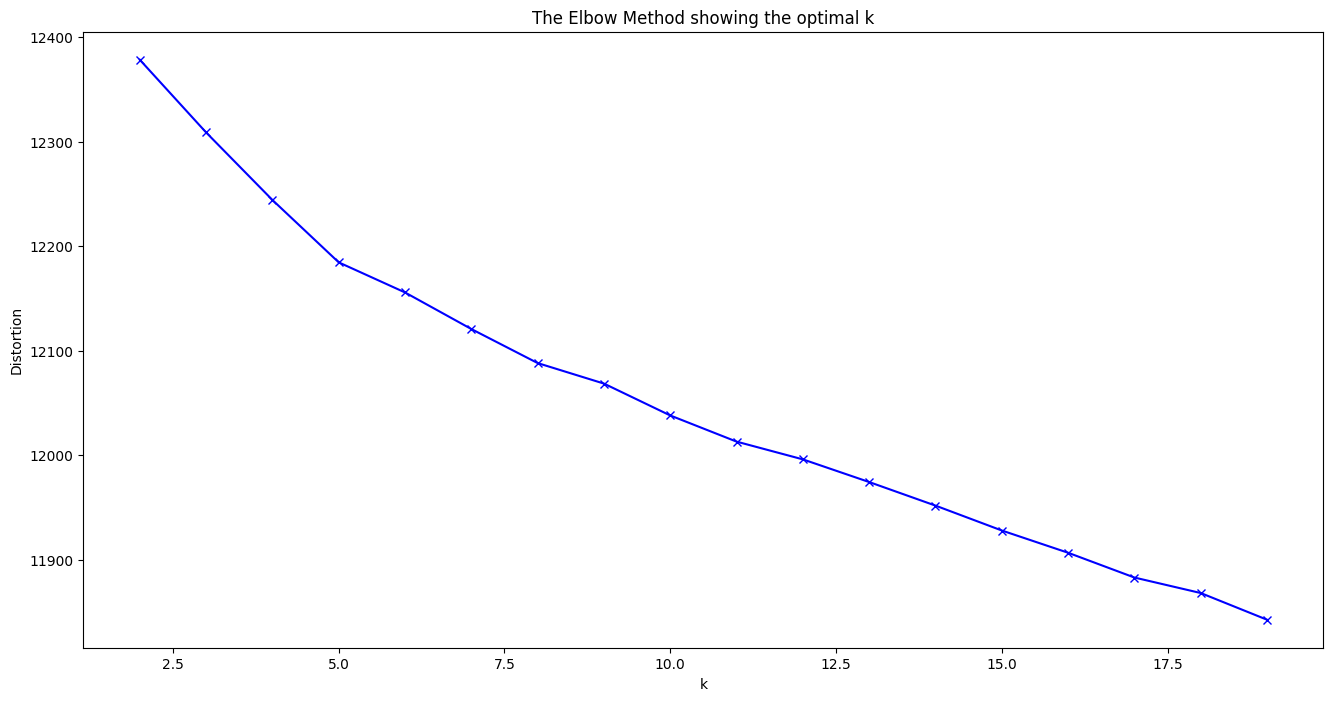

In [38]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Menurut saya, Nilai K yang terbaik adalah 9 dikarenakan silhouette score dikarenakan tidak terjadi perubahan silhouette score yang besar untuk K selanjutnya. Hal ini juga dapat dilihat pada elbow method, tidak terjadi banyak perubahan dari kluster 5 dan seterusnya, namun pada 8 ke 9 terjadi penurunan distortion yang signifikan. Oleh sebab itu saya memilih K=9.

## Persona Analysis for The Best K Value

In [39]:
# Persona analysis for K=9
kmeans_model = KMeans(n_clusters=9)
cluster_labels = kmeans_model.fit_predict(text_tfidf)

In [12]:
from collections import Counter

def analyze_persona(cluster_texts):
    words = ' '.join(cluster_texts).split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(10)
    
    return common_words


In [54]:
for cluster_id in range(9):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_texts = [text_clean[i] for i in cluster_indices]
    
    # Analyze the persona for this cluster (e.g., common words, themes, etc.)
    persona_analysis = analyze_persona(cluster_texts)
    
    print(f"\nPersona Analysis for Cluster {cluster_id}:")
    print(persona_analysis)


Persona Analysis for Cluster 0:
[('and', 10309), ('the', 9884), ('of', 6301), ('to', 6184), ('a', 5400), ('for', 5131), ('with', 4379), ('in', 4039), ('is', 3840), ('your', 3654)]

Persona Analysis for Cluster 1:
[('and', 2208), ('of', 1471), ('for', 1443), ('the', 1416), ('cotton', 1110), ('to', 1079), ('a', 949), ('with', 919), ('men', 803), ('s', 800)]

Persona Analysis for Cluster 2:
[('the', 5808), ('and', 5038), ('to', 3329), ('a', 2858), ('of', 2697), ('for', 2556), ('with', 2551), ('is', 1958), ('in', 1957), ('your', 1558)]

Persona Analysis for Cluster 3:
[('and', 4171), ('the', 4169), ('to', 3015), ('with', 2514), ('a', 1935), ('your', 1585), ('for', 1582), ('you', 1552), ('of', 1506), ('usb', 1400)]

Persona Analysis for Cluster 4:
[('the', 2002), ('and', 1039), ('of', 632), ('content', 559), ('in', 510), ('to', 441), ('students', 367), ('team', 273), ('book', 247), ('books', 245)]

Persona Analysis for Cluster 5:
[('and', 2448), ('the', 1557), ('for', 1500), ('to', 1414), 

Cluster 0: tidak memberikan insight yang banyak hanya berupa kata hubung.<br>
Cluster 1: tidak memberikan insight yang banyak hanya berupa kata hubung, terdapat kata men dan cotton yang berbeda. <br>
Cluster 2: Sama dengan cluster 0 <br>
Cluaster 3: tidak ada insight bagus namun ada kata usb yang mungkin mengidikasikan sesuatu <br>
Cluster 4: Sepertinya membahas tentang sekolah karena terdapat student dan book <br>
Cluster 5: Tidak terdapat hal yang menarik, hanya 'women' <br>
CLuster 6: tidak memberikan insgiht yang baik. <br>
Cluster 7: Tidak terdapat insight menarik. <br>
Cluster 8: Tidak terdapat insight baik. <br>

## Topic Extraction

Latent Dirichlet Allocation (LDA) adalah metode populer untuk pemodelan topik dan clustering data teks. Ini adalah model yang memungkinkan serangkaian pengamatan dijelaskan oleh kelompok yang tidak teramati yang menjelaskan mengapa beberapa bagian dari data tersebut serupa. Pendekatan ini sangat berguna untuk menganalisis data teks di mana dokumen dapat dianggap sebagai bag of words, yaitu kumpulan kata di mana urutan kata tidak menjadi masalah.

For n_clusters = 2 The average silhouette_score is : 0.10829752355066546
For n_clusters = 3 The average silhouette_score is : 0.1190471792138932
For n_clusters = 4 The average silhouette_score is : 0.04325650461693602
For n_clusters = 5 The average silhouette_score is : 0.048234492123649296
For n_clusters = 6 The average silhouette_score is : 0.025159597848634252
For n_clusters = 7 The average silhouette_score is : 0.038316209286379944
For n_clusters = 8 The average silhouette_score is : 0.05184312376590603
For n_clusters = 9 The average silhouette_score is : 0.01881630767666291
For n_clusters = 10 The average silhouette_score is : 0.03745606400165108
For n_clusters = 11 The average silhouette_score is : 0.026464478141310487
For n_clusters = 12 The average silhouette_score is : 0.026052321085204617
For n_clusters = 13 The average silhouette_score is : 0.022730558606961535
For n_clusters = 14 The average silhouette_score is : 0.022909849796414056
For n_clusters = 15 The average silhouet

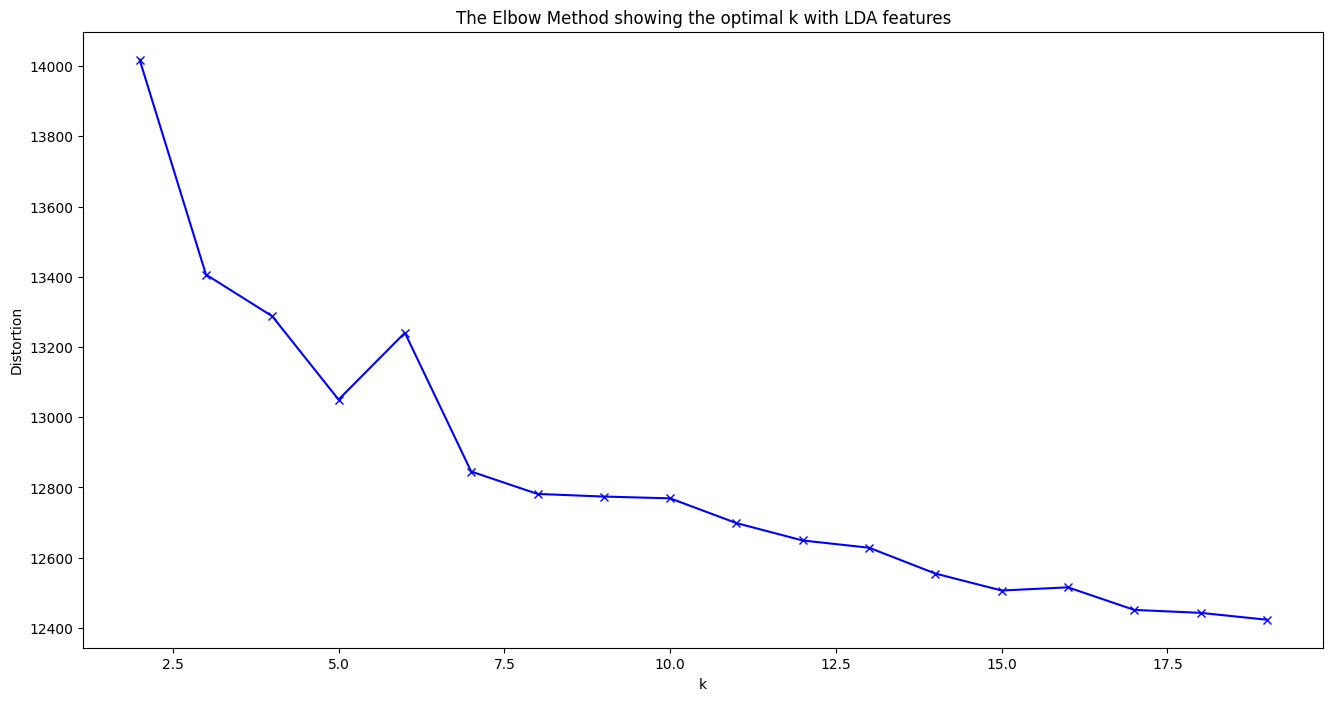

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 9  

# Create the TF-IDF matrix
vectorizer = TfidfVectorizer()
text_tfidf = vectorizer.fit_transform(text_processed)

lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda.fit_transform(text_tfidf)

text_tfidf_lda = np.hstack((text_tfidf.toarray(), lda_topics))

distortions_lda = []
K_lda = range(2, 20)
for k in K_lda:
    kmeanModel_lda = KMeans(n_clusters=k,max_iter=15,n_init=1)
    cluster_label_lda = kmeanModel_lda.fit_predict(text_tfidf_lda)
    silhouette_avg_lda = silhouette_score(text_tfidf_lda, cluster_label_lda)
    print(
        "For n_clusters =", k,
        "The average silhouette_score is :", silhouette_avg_lda,
    )
    distortions_lda.append(kmeanModel_lda.inertia_)

plt.figure(figsize=(16, 8))
plt.plot(K_lda, distortions_lda, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k with LDA features')
plt.show()

Menurut saya, Nilai K yang terbaik adalah 8 dikarenakan silhouette score yang besar. Hal ini juga dapat dilihat pada elbow method, tidak terjadi banyak perubahan dari kluster 8 dan seterusnya. Oleh sebab itu saya memilih K=8.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 9  

# Create the TF-IDF matrix
vectorizer = TfidfVectorizer()
text_tfidf = vectorizer.fit_transform(text_processed)

lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda.fit_transform(text_tfidf)

text_tfidf_lda = np.hstack((text_tfidf.toarray(), lda_topics))

optimal_k_lda = 8  
kmeanModel_optimal_lda = KMeans(n_clusters=optimal_k_lda,max_iter=15,n_init=1)
cluster_labels_lda = kmeanModel_optimal_lda.fit_predict(text_tfidf_lda)

In [13]:
for cluster_id_lda in range(optimal_k_lda):
    cluster_indices_lda = np.where(cluster_labels_lda == cluster_id_lda)[0]
    cluster_texts_lda = [text_clean[i] for i in cluster_indices_lda]

    persona_analysis_lda = analyze_persona(cluster_texts_lda)

    print(f"\nPersona Analysis for Cluster {cluster_id_lda}:")
    print(persona_analysis_lda)


Persona Analysis for Cluster 0:
[('the', 6779), ('and', 6665), ('of', 4165), ('to', 4029), ('a', 3602), ('for', 3204), ('in', 2688), ('with', 2603), ('is', 2581), ('your', 1812)]

Persona Analysis for Cluster 1:
[('the', 18165), ('and', 13009), ('of', 12643), ('a', 7600), ('in', 6480), ('to', 6217), ('is', 4463), ('for', 3320), ('s', 2878), ('he', 2487)]

Persona Analysis for Cluster 2:
[('the', 7833), ('and', 7496), ('to', 5531), ('with', 4914), ('a', 3844), ('for', 3054), ('you', 3047), ('your', 2954), ('of', 2928), ('in', 2759)]

Persona Analysis for Cluster 3:
[('the', 397), ('and', 314), ('of', 216), ('to', 208), ('for', 169), ('in', 131), ('book', 122), ('a', 116), ('with', 75), ('s', 68)]

Persona Analysis for Cluster 4:
[('the', 1994), ('and', 1023), ('of', 670), ('content', 523), ('in', 512), ('students', 390), ('to', 376), ('for', 290), ('exam', 235), ('books', 227)]

Persona Analysis for Cluster 5:
[('and', 1411), ('the', 1027), ('to', 837), ('of', 807), ('for', 752), ('a',

K-Means LDA with K=8 <br>
Cluster 0: tidak memberikan insight yang banyak.<br>
Cluster 1: tidak memberikan insight yang banyak. <br>
Cluster 2: Sama dengan cluster 0 <br>
Cluaster 3: tidak ada insight bagus namun ada kata usb yang mungkin mengidikasikan sesuatu <br>
Cluster 4: Sepertinya membahas tentang sekolah karena terdapat student, book, dan exam. <br>
Cluster 5: Tidak terdapat hal yang menari <br>
CLuster 6: tidak memberikan insgiht yang baik. <br>
Cluster 7: Tidak terdapat insight menarik. <br>

## Persona Analysis for Topic Extraction and Comparing to Clustering

K-Means with K=9 <br>
Cluster 0: tidak memberikan insight yang banyak hanya berupa kata hubung.<br>
Cluster 1: tidak memberikan insight yang banyak hanya berupa kata hubung, terdapat kata men dan cotton yang berbeda. <br>
Cluster 2: Sama dengan cluster 0 <br>
Cluaster 3: tidak ada insight bagus namun ada kata usb yang mungkin mengidikasikan sesuatu <br>
Cluster 4: Sepertinya membahas tentang sekolah karena terdapat student dan book <br>
Cluster 5: Tidak terdapat hal yang menarik, hanya 'women' <br>
CLuster 6: tidak memberikan insgiht yang baik. <br>
Cluster 7: Tidak terdapat insight menarik. <br>
Cluster 8: Tidak terdapat insight baik. <br>

K-Means LDA with K=8 <br>
Cluster 0: tidak memberikan insight yang banyak.<br>
Cluster 1: tidak memberikan insight yang banyak. <br>
Cluster 2: Sama dengan cluster 0 <br>
Cluaster 3: tidak ada insight bagus namun ada kata usb yang mungkin mengidikasikan sesuatu <br>
Cluster 4: Sepertinya membahas tentang sekolah karena terdapat student, book, dan exam. <br>
Cluster 5: Tidak terdapat hal yang menari <br>
CLuster 6: tidak memberikan insgiht yang baik. <br>
Cluster 7: Tidak terdapat insight menarik. <br>

Bisa dilihat bahwa hasil pertama dan kedua memiliki hasil yang mirip yaitu, hanya terdapat 1 cluster yang dapat mengidentifikasi sesuatu yang berkmakna yaitu tentang sekolah atau pendidikan pada cluster = 4 untuk KMeans dan cluster=8 untuk KMeans dengan LDA

Hasil clustering ini sangat buruk karena tidak dapat mengsegmentasi apapun dalam text yang diberikan, mungkin diperlukan preprocessing data yang lebih baik atau tuning model agar memebrikan performa yang lebih baik dalam clustering

## <p style="border: 2px solid black; font-family: Arial, sans-serif; font-size: 200%; text-align: center; color: black; padding: 10px;border-radius: 10px;">3. Text Summarization</p>

Metode text summarization yang saya gunakan adalah extractive method, dimana sumarization ini memilih dan menggabungkan kalimat dari raw text dengan menjaga keutuhan informasi.

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.tokenize.treebank import TreebankWordDetokenizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def extractive_summarization(text, top_n):
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalnum() and word.lower() not in stopwords.words('english')]

    frequency_distribution = FreqDist(words)

    scores = {}
    for i, sentence in enumerate(sentences):
        score = sum(frequency_distribution[word] for word in word_tokenize(sentence.lower()) if word.isalnum())
        scores[i] = score

    sorted_indices = sorted(scores, key=scores.get, reverse=True)
    selected_indices = sorted_indices[:top_n]
    selected_indices.sort()

    summary = [sentences[i] for i in selected_indices]
    detokenizer = TreebankWordDetokenizer()
    summarized_text = detokenizer.detokenize(summary)

    return summarized_text

Extractive summarization bekerja dengan cara membuat distribusi frekuensi menggunakan 'FreqDist', lalu tiap kalimat diranking berdasarkan kata-kata yang mebangunnya, penggunaan top_n bertujuan untuk memilih top sentence dengan skor terbesar. Hasilnya merupakan gabungan kalimat dari top sentence tersebut.

In [2]:
with open('/kaggle/input/data-3c/data_3C.txt', 'r', encoding='utf-8') as file:
    text_content = file.read()

In [7]:
top3_summary = extractive_summarization(text_content, top_n=3)
top5_summary = extractive_summarization(text_content, top_n=5)

In [3]:
text_content

'\ufeffBagi penggemar K-pop, Korea Selatan adalah negara impian untuk didatangi. Negara indah yang memadukan tradisi dan modernitas ini menawarkan beragam pengalaman kepada wisatawan. Bagi para penggemar K-pop, mengunjungi Korea Selatan bukan sekedar liburan, namun juga "ziarah" ke pusat fenomena K-pop global. Berikut beberapa destinasi yang jadi favorit para penggemar K-pop di Korea Selatan. 1.Seoul, Ibu Kota Korea Selatan ini memadukan tradisi dan modernitas, misalnya ada istana kuno dengan teknologi mutakhir. Di Seoul wisatawan bisa menjelajahi Istana Gyeongbokgung yang bersejarah, berjalan-jalan melalui distrik trendi di Gangnam, dan nikmati kuliner jalanan yang semarak di Pasar Gwangjang. Jangan lewatkan panorama dari N Seoul Tower dan semaraknya suasana kawasan perbelanjaan Myeongdong.2. Pulau Jeju, Dikenal sebagai Pulau Para Dewa, Jeju menawarkan pelarian yang menakjubkan dengan lanskap vulkanik di Taman Nasional Hallasan, Puncak Seongsan Ilchulbong yang ikonik, dan pantai indah

In [8]:
print("Top 3 Summary:")
print(top3_summary)
print("\nTop 5 Summary:")
print(top5_summary)

Top 3 Summary:
Di Seoul wisatawan bisa menjelajahi Istana Gyeongbokgung yang bersejarah, berjalan-jalan melalui distrik trendi di Gangnam, dan nikmati kuliner jalanan yang semarak di Pasar Gwangjang. Pulau Jeju, Dikenal sebagai Pulau Para Dewa, Jeju menawarkan pelarian yang menakjubkan dengan lanskap vulkanik di Taman Nasional Hallasan, Puncak Seongsan Ilchulbong yang ikonik, dan pantai indah seperti Jungmun Saekdal untuk bersantai.3. Incheon, Incheon bukan hanya rumah bagi bandara terbesar Korea Selatan, tapi banyak hal lain yang bisa dijelajahi seperti Chinatown yang semarak, Jembatan Besar Incheon yang indah, dan Kawasan Bisnis Internasional Songdo dengan artistektur modern.

Top 5 Summary:
Di Seoul wisatawan bisa menjelajahi Istana Gyeongbokgung yang bersejarah, berjalan-jalan melalui distrik trendi di Gangnam, dan nikmati kuliner jalanan yang semarak di Pasar Gwangjang. Pulau Jeju, Dikenal sebagai Pulau Para Dewa, Jeju menawarkan pelarian yang menakjubkan dengan lanskap vulkanik d

Top 3 summary terlihat lebih pendek dibandingkan top 5 summary, namun pada top 3 summary ini hanya membahas beberapa destinasi, seperti tidak membahas busan. Pada top 5 summary namun lebih lengkap dibandingkan top 3 summary dengan membawa busan. <br>
Menurut saya, Top 5 summary lebih baik dikarenakan lebih mamahas banyak destinasi dibandingkan top 3 summary, panjang dari sumary top 5 juga tidak terlalu berbeda signifikan dengan top 3 summary.